# Analysis file for Ariane quantitative runs
gets data from .nc file into basic plot<br>
based on code from https://github.com/SalishSeaCast/analysis-susan/blob/master/notebooks/Ariane/FluxRobertsBankApr2015-New.ipynb

In [1]:
import cmocean.cm as cm
import glob
from matplotlib.colors import LogNorm, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

import scipy.interpolate as interp

from salishsea_tools import nc_tools, geo_tools

%matplotlib inline

### get grid info

In [2]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

### Hourly particle crossing, 1 day run

In [3]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/JDF_salish/14sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
time1 = mydata.init_t[0]

In [4]:
def get_data(mydata, section, time):
    lons = mydata.final_lon[(mydata.final_section==section) & (mydata.init_t==time)]
    depths = depthf(mydata.final_z[(mydata.final_section==section) & (mydata.init_t==time)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section) & (mydata.init_t==time)]
    return lons, depths, transports

#### SoG3

In [5]:
section = 4

figrid = 266 #fortran igrid
igrid = figrid-1
fmask = mymesh.fmask[0, :, igrid]
tmask = mymesh.tmask[0]
nav_lon = mymesh.nav_lon[igrid]
u_lons = mymesh.glamv[0, igrid]    # note switch to v with the switch from t to f
f_lons = mymesh.glamf[0, igrid]
w_depths = mymesh.gdepw_1d

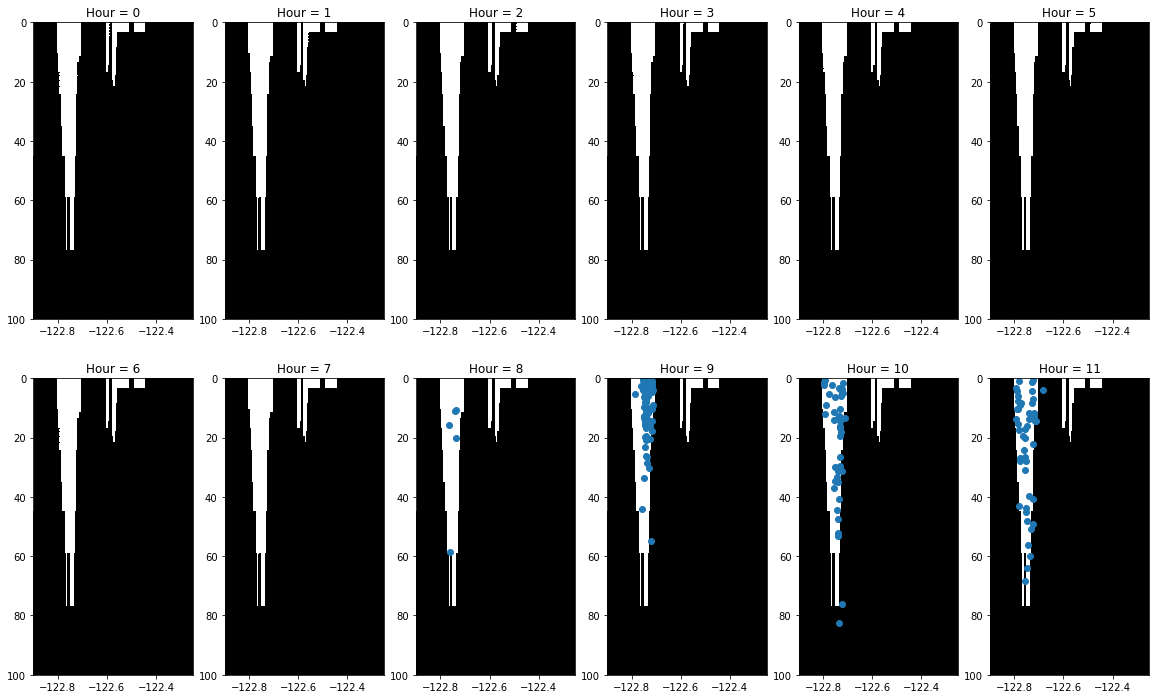

In [6]:

fig, axs = plt.subplots(2, 6, figsize=(20, 12))
x, y = np.meshgrid(u_lons, w_depths)
for hour in range(12):
    ax = axs[int(hour/6), hour-6*int(hour/6)]
    lons, depths, transports = get_data(mydata, section, time1+hour)
    ax.pcolormesh(x, y, fmask, cmap='Greys_r',  shading='auto')
    ax.plot(lons, depths, 'o')
    ax.invert_yaxis()
    ax.set_xlim((-122.9, -122.25))
    ax.set_ylim((100, 0))
    ax.set_title("Hour = "+str(hour))

clearly taking the figrid from sections.txt doesn't QUITE work (especially visible in hour 11 where many of the particles come in at a deph that is ground according to the grid)

## Daily flux, 1 day run

In [7]:
salfile = '/results/SalishSea/nowcast-green.201812/14sep17/SalishSea_1d_20170914_20170914_grid_T.nc'

In [8]:
def draw_patches(fmask, ll, ul, u_lons, w_depths): #draw ground part of cross section
    topo = []
    for i in range(ll,ul):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((u_lons[i], w_depths[j]), u_lons[i+1]-u_lons[i], w_depths[j+1]-w_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='burlywood', edgecolors='burlywood')
    return(pc)

### Method 1: get grid cell size based on location of parcel (which cell it is within) divide by grid area before plotting
In my mind this should work but very slow<br>
all data analysed in m, plotted in x direction according to longitude

In [9]:
def Speed(lons, depths, transports, figrid): #gets cell size information to convert tranport thorugh a cell to speed (m/s)
    igrid = figrid -1
    length = len(lons)
    
    depth_ind = np.zeros(length)
    lon_ind = np.zeros(length)
    speed = np.zeros(length)
    
    #compare depth of data point to depth in mymesh.gdepw_1d to find out which cell the data point is from in depth direction (40 options)
    for i in range(length):
        for j in range(len(mymesh.gdept_1d[0])-1):
            if depths[i] > mymesh.gdept_1d[0][j] and depths[i] < mymesh.gdepw_1d[0][j+1]:
                depth_ind[i] = j
            elif depths[i] > mymesh.gdept_1d[0][j+1]:
                depth_ind[i]= len(mymesh.gdept_1d[0])-1
    
    #uses index from previous step to get height of cells at this depth
    depth_width = [mymesh['e3t_0'][0,int(depth_ind[i]),0,0].values for i in range(length)]
    
    #compare longitude of data point to depth in mymesh.nav_lon to find out which cell the data point is from in longitudinal direction (389 options)
    for i in range(length):
        for j in range(len(mymesh.nav_lon[igrid])-1):
            if lons[i] > mymesh.nav_lon[igrid][j] and lons[i] < mymesh.nav_lon[igrid][j+1]:
                lon_ind[i] = j
                
    lon_width = [mymesh['e1t'][0,igrid,int(lon_ind[i])].values for i in range(length)] #grid spacing on T-grid in u direction in m
    
    speed = [transports[i]/(depth_width[i]*lon_width[i]) for i in range(length)]
    
    return speed

In [10]:
def speedCS(section, lonW, lonE, figrid, maxdepth, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid] #why using vorticity grid?
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    t_lons = mymesh.glamt[0, igrid]    # note switch to v with the switch from t to f
    f_lons = mymesh.glamf[0, igrid]
    t_depths = mymesh.gdept_1d
    
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e2t[0, igrid, lonW:lonE].sum()))
    xs, ys = np.meshgrid(np.array(t_lons), np.array(t_depths))
    
    lons = mydata.final_lon[(mydata.final_section==section)]
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]
    speed = Speed(lons, depths, transports, figrid)
    
    vmax = max(speed)
        
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    c, xedge, yedge, im = ax.hist2d(lons, 
                            depths,
                            weights=speed,
                            bins=[np.array(t_lons[lonW:lonE]), t_depths[0]], cmap=cm.amp, vmax=vmax)
    
    pc = draw_patches(fmask, lonW, lonE, np.array(t_lons), np.array(t_depths[0]))
    ax.add_collection(pc)
    cb1 = fig.colorbar(im, ax=ax) 
    cb1.set_ticks([0, vmax])
#     cb1.set_ticklabels([0, f'{vmax * float(m2lon) * float(transports.sum())/24.:.2f}'])
    cb1.set_label('m s$^{-1}$', labelpad=-20)
    salinity = 0.5*(np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid],
                    mask=1-tmask[:, igrid]) +
                np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid+1],
                    mask=1-tmask[:, igrid+1]))
    CS = ax.contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g')
    ax.clabel(CS, inline=1, fontsize=7)
    ax.invert_yaxis()
    # ax.set_xlim((-123.32, -123.05))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()
    
    return c,xedge, yedge, transports, m2lon

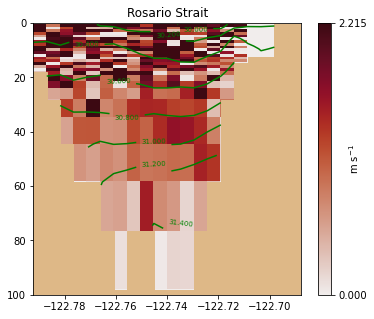

In [11]:
count, xedge, yedge, trans, m2lon = speedCS(4, 286, 307, 266, 100, "Rosario Strait")

wooooo works! next step is to make a csv file of all the cross section grid size information because that part takes an aggressive amount of time to run. this is under the assumption that as long as the cross sections are the same in sections.txt/ segrid that the tranpsorts, depths, and lons arrays would be the same length. fingers crossed! - LOL NOPE! back to the drawing board..

In [98]:
xdist = [(xedge[i+1]-xedge[i]) for i in range(count.shape[0])]
ydist = [yedge[i+1]-yedge[i] for i in range(count.shape[1])]

grid_flow1 = np.zeros(count.shape)
for i in range(count.shape[0]):
    for j in range(count.shape[1]):
        grid_flow1[i,j] = count[i,j] * xdist[i] * ydist[j]

In [99]:
sum(sum(grid_flow1))

1.0000000000000002

In [100]:
sum(trans)

<xarray.DataArray 'final_transp' ()>
array(844510.11102014)

### Method 2: susan's code, notably with density=True (new version of normed=True)
values much smaller than method 1 (max around 0.15 instead of 2.2) <br>
concern that giving the horizontal bins in longitude and the vertical bins in m will make the density funtion not work, assumes that the bins given in both directions are the same units <br>

APPARENTLY the vmax calcualtation "takes care of" the conversion to meters in the x-direction but i REALLY don't understand why that would be the case - accroding to my understanding the vmax is just the colourbar range, furthermore how its written it doesnt really involve the m2lon value since it will equal no matter what whatever the first term in the vvmax equaiton is. ALSO the density function will normalise the data within vmax but i still dont see how this is giving me the converted to meters values??

In [10]:
def transportCS(section, lonW, lonE, figrid, maxdepth, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    t_lons = mymesh.glamt[0, igrid]    # longitude of T-grid points
    f_lons = mymesh.glamf[0, igrid]    # longitude of vorticity-grid points
    t_depths = mymesh.gdept_1d         # nominal depth of T-grid points
   
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum())) #look into whether this should be e2t or e1t
    tmax = 997
    vvmax = 0.15/float(m2lon)*24/tmax
    xs, ys = np.meshgrid(np.array(t_lons), np.array(t_depths))
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    lons = mydata.final_lon[(mydata.final_section==section)]
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]
    
    vmax = vvmax*tmax/float(transports.sum())
    
    
    c, xedge, yedge, im = ax.hist2d(lons, 
                            depths,
                            weights=transports,
                            bins=[np.array(t_lons[lonW:lonE]), t_depths[0]], cmap=cm.amp, vmax=vmax, density=True)
    
    pc = draw_patches(fmask, lonW, lonE, np.array(t_lons), np.array(t_depths[0]))
    ax.add_collection(pc)
    cb1 = fig.colorbar(im, ax=ax) 
    cb1.set_ticks([0, vmax])
    cb1.set_ticklabels([0, f'{vmax * float(m2lon) * float(transports.sum())/24.:.2f}'])
    cb1.set_label('m s$^{-1}$', labelpad=-20)
    salinity = 0.5*(np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid],
                    mask=1-tmask[:, igrid]) +
                np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid+1],
                    mask=1-tmask[:, igrid+1]))
    CS = ax.contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g')
    ax.clabel(CS, inline=1, fontsize=7)
    ax.invert_yaxis()
    # ax.set_xlim((-123.32, -123.05))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()
    
    return c,xedge, yedge, transports, m2lon

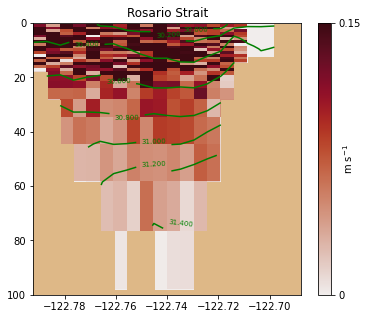

In [11]:
count, xedge, yedge, trans, m2lon = transportCS(4, 286, 307, 266, 100, "Rosario Strait")

In [12]:
total_weights = sum(trans)/max(trans)
xdist = np.diff(xedge)
ydist = np.diff(yedge)

weights = np.zeros(count.shape)
for i in range(count.shape[0]):
    for j in range(count.shape[1]):
        weights[i,j] = count[i,j] * xdist[i] * ydist[j] * total_weights * max(trans)

KeyboardInterrupt: 

In [28]:
sum(sum(weights))

844510.111020138

In [31]:
print(count[0][0]*(sum(trans)))
print(count[0][0]*(max(trans)))

<xarray.DataArray 'final_transp' ()>
array(243981.67006613)
<xarray.DataArray 'final_transp' ()>
array(287.98947154)
Attributes:
    title:     What is final_transp ?
    longname:  Final transport
    units:     m3/s


In [12]:
# xdist = [(xedge[i+1]-xedge[i])/m2lon.values for i in range(count.shape[0])]
# ydist = [yedge[i+1]-yedge[i] for i in range(count.shape[1])]

# grid_flow = np.zeros(count.shape)
# for i in range(count.shape[0]):
#     for j in range(count.shape[1]):
#         grid_flow[i,j] = count[i,j] * xdist[i] * ydist[j]

In [13]:
# sum(sum(grid_flow))

84048.76522377493

In [14]:
sum(trans)

<xarray.DataArray 'final_transp' ()>
array(844510.11102014)

### Method 3: spoke with Elise, she suggested converting to m in longitudinal direction to keep consistent
think maybe that the problem in the aboe (transportsCS) is that the density=true part is trying to divide the data by the grid cell size to noramlize BUT the date in the x direction is in longitude, while in the z direction is in m <br>
must get them both in meters to compare properly and for density to work <br>

In [13]:
#identical to draw_patches function ealier, but added line to create rectangles with relative meter coordinates instead
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='burlywood', edgecolors='burlywood', zorder=3)
    return(pc)

In [42]:
def tranCS(section, lonW, lonE, figrid, maxdepth, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    
    lons = mydata.final_lon[(mydata.final_section==section)]
    lats = mydata.final_lat[(mydata.final_section==section)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    c, xedge, yedge, im = ax.hist2d(dist, 
                            depths,
                            weights=transports, #so vmax is the conversion to m part? if we take it out with our conversion already done will it be the same as method 2?
                            bins=[np.array(t_dist[lonW:lonE]), t_depths], cmap=cm.amp, density=True, zorder=1) 
    
    salinity = 0.5*(np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid],
            mask=1-tmask[:, igrid]) +
            np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid+1],
            mask=1-tmask[:, igrid+1]))
    CS = ax.contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g', zorder = 2)
    
    pc = draw_patches(fmask, lonW, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)
    cb1 = fig.colorbar(im, ax=ax) 
    cb1.set_ticks([0, 0.15])
    cb1.set_ticklabels([0, 0.15])
    cb1.set_label('m s$^{-1}$', labelpad=-20)

    ax.clabel(CS, inline=1, fontsize=7)
    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()
    
    return c,xedge, yedge, transports, t_dist

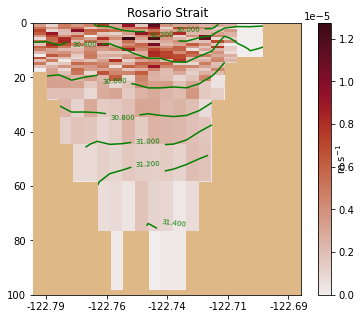

In [43]:
count, xedge, yedge, trans, t_dist = tranCS(4, 286, 307, 266, 100, "Rosario Strait")

In [35]:
total_weights = sum(trans)/max(trans)
xdist = np.diff(xedge)
ydist = np.diff(yedge)

weights3 = np.zeros(count.shape)
for i in range(count.shape[0]):
    for j in range(count.shape[1]):
        weights3[i,j] = count[i,j] * xdist[i] * ydist[j] * total_weights * max(trans)

In [38]:
print(count[0][0]*(sum(trans)))
# print(count[0][0]*(max(trans)))

<xarray.DataArray 'final_transp' ()>
array(2.90285847)


In [ ]:
sum(sum(weights3))

In [95]:
xdist = [(xedge[i+1]-xedge[i]) for i in range(count.shape[0])]
ydist = [yedge[i+1]-yedge[i] for i in range(count.shape[1])]

grid_flow = np.zeros(count.shape)
for i in range(count.shape[0]):
    for j in range(count.shape[1]):
        grid_flow[i,j] = count[i,j] * xdist[i] * ydist[j]

In [96]:
sum(sum(grid_flow))

1.0000000000000002

converted everything (i think) in the function to m instead of longitude but getting the above plot where data is plotted but all speeds=0. really not sure why. <br>
i'm assuming that slight visual differences in salinity cross-sections is due to error associates with lon-m conversion but i'm not sure where those green lines on the RHS come from <br>
NEXT STEP = keep going in this direction, but try using Ben's more broken up version of the histogram code. i think that will help you understand better what is going on/how to fix it

### Method 4: similar to method 4, but upon Ben's suggestion using different histrogram function (np.histogram2d instead of plt.hist2d) which may be more intuitive

In [20]:
def tranCS(section, lonW, lonE, figrid, maxdepth, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    
    lons = mydata.final_lon[(mydata.final_section==section)]
    lats = mydata.final_lat[(mydata.final_section==section)]
    lon1 = min(lons)-0.001 #westernmost longitude
    lat1 = min(lats) #southernmost latitude, used as constant for all percels since CS varies in E-W the effect of N-S is marginal
    t_lons = mymesh.glamt[0, igrid]    # note switch to v with the switch from t to f
    t_dist = [float(geo_tools.haversine(lon1, lat1, t_lons[i], lat1))*1000 for i in range(len(u_lons))] #converts lon to relative m distance along lon
#     f_lons = mymesh.glamf[0, igrid]
#     f_dist = [float(geo_tools.haversine(lon1, lat1, f_lons[i], lat1))*1000 for i in range(lonW,lonE)] #converts lon to relative distance along lon
    t_depths = mymesh.gdept_1d
    
    dist = [float(geo_tools.haversine(lon1, lat1, lons[i], lat1))*1000 for i in range(len(lons))] #gives dist of particles along CS
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]
   
#     tmax = max(transports)
#     vvmax = 0.15/float(m2lon)*24/tmax #vmax will end up as whatever is the first number in this term
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    vmax = 0.000015#vvmax*tmax/float(transports.sum())
    
    # Plot data
    xedges, yedges = np.array(t_dist[lonW:lonE]), t_depths[0]
    H, _, _ = np.histogram2d(dist, depths, bins=(xedges, yedges), weights= transports, density = True)
    c = ax.pcolormesh(xedges, yedges, np.ma.masked_equal(H.T, 0), vmin=0, vmax=vmax, cmap=cm.amp)
#     ax.add_patch(patches.Rectangle((-125.25, 49.5), 1.4, 0.5, fill=False, ec='k', linewidth=2.5, transform=proj_ref, zorder=2))
    
    pc = draw_patches(fmask, lonW, lonE, lon1, lat1, np.array(t_lons), np.array(t_depths[0]))
    ax.add_collection(pc)
    ax.set_ylim((100,0))

    mydata.close()



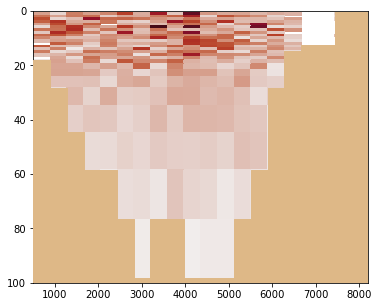

In [21]:
tranCS(4, 286, 307, 266, 100, "Rosario Strait")